In [79]:
# Set up working directory & Import necessary
import os
os.chdir('/Users/zepedalab/Desktop/MATHia_NLP_YB')

import pandas as pd # for manipulating dataframe
import re # for regular expression
import spacy #for NLP analysis
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [80]:
# Import Data File
text_df = pd.read_excel('/Users/zepedalab/Desktop/MATHia_NLP_YB/NLP Dataset.xlsx')

In [81]:
# Pre-process the text data (text_df)
# Convert the text input to the lower case string
# Remove all non-alphabetic characters
text_df['input'] = text_df['input'].astype(str)
text_df['input'] = text_df['input'].str.lower()
text_df['input'] = text_df['input'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Filter out any input that comprise less than 3 characters
text_df = text_df[text_df['input'].str.len() >= 3]
short_input_df = text_df[text_df['input'].str.len() < 3] #short_input_df allows us to manually check

In [82]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [83]:
# Quicklook on the first 10 nonsense string
nonsense_df.input[:10]

4                                  jjjnnknjmimkkikiilkin
99                                           ummmmmm idk
103    jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj...
159                                              yayyyyy
162    dddddddddddddddddddddddddddddddddddddddddddddd...
263                            iiiiiiiiiiiiiiiiiiiiii kj
359                                           v guvghibj
463                                             ndcfksdj
480                                   ibhuiygutgcytuyvjh
505                                               jkkkkk
Name: input, dtype: object

In [84]:
# Pre-process those shor input by using the gibberish detector
from gibberish_detector import detector
Detector = detector.create_from_model('/Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model')

In [85]:
gibberish_indices = []

# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [86]:
# Quicklook on the first 10 gibberish string
gibberish_df.input[:10]

93      bruhhhh
111    r gtktnq
113         idk
190         idk
191         idk
193         kjh
213        kklj
246         idk
254        jhgj
258         idk
Name: input, dtype: object

In [87]:
# Load spacy model
nlp = spacy.load("en_core_web_lg")

# Define a helper function to process text using spaCy
def spacy_preprocessor(texts):
    processed_docs = []
    # disable parser and ner for speed since we only need tokenization/lemmatization
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        # Lemmatize, lowercase, remove stopwords and non-alphabetic chars
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        processed_docs.append(tokens)
    return processed_docs

# Call the helper function for Tokenize and lemmatize
tokenized_docs = spacy_preprocessor(text_df['input'].astype(str))

# Add tokens to dataframe temporarily to keep alignment safe
text_df['tokens'] = tokenized_docs

# Filter rows where the token list is not empty
text_df_filtered = text_df[text_df['tokens'].map(len) > 0].copy()

# Create the filtered docs list for Gensim
filtered_docs = text_df_filtered['tokens'].tolist()

# Create the cleaned string representation
text_df_filtered["cleaned_input"] = text_df_filtered['tokens'].apply(lambda x: ' '.join(x))


In [88]:
import gensim
from gensim import corpora
# create empty dictionary from gensim library (for the vocabulary)
dictionary = gensim.corpora.Dictionary()
# iteratively add each doc to the bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in filtered_docs]

In [89]:
import numpy as np

# Get vocab from dictionary
vocab = pd.Series(dictionary.token2id).index

# Sequence of numbers as long as the documents
index = range(len(bow_corpus))

# Create a pandas dataframe full of zeros.
bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float32),
                  index=index, # row labels
                  columns=vocab) #column labels

# Add each word from the bag-of-words corpus to the matrix.
for idx in index:
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# Transpose the matrix for easy reading
bow_df

,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
563,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
# Calculating Inverse Document Frequency
num_documents = len(bow_df) #get the length of the documents

# function of idf
def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()    # sum of documents containing the term
  return np.log(num_documents+1/documents_containing_term+1)  # divide the number of documents by the num documents with the term and get the log.

# dictionary comprehension to apply the idf function to every word (column) in the bow_df DataFrame
idf = pd.Series({term:idf(term) for term in bow_df.columns}) # create dictionary with key value pair of term:idf(term)

#Calculate Term Frequency
# divide each token count by the total token count for the row.
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

#Calculate the TF-IDF score
tfidf_df = tf_df.copy().multiply(idf, axis='columns')
# make copy of tf_df that is tf/idf

# Quick view on tf-idf metrix
tfidf_df[:10]



,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,2.114627,2.114094,2.114114,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.00000,1.40939,0.704778,0.704876,0.704876,0.704692,0.704687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.906027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Anon.Student.Id,input,Invalid Response,Effort,Performance Self-Talk,Willpower,tokens,cleaned_input
0,stu_NWRXR49435,that i will awaly do better then last time,0,0.0,1,0,"[awaly, well, time]",awaly well time
2,stu_KAIDW62100,nan,1,0.0,0,0,[nan],nan
3,stu_KAIDW62100,nan,1,0.0,0,0,[nan],nan
7,stu_PLFUT13166,nan,1,0.0,0,0,[nan],nan
8,stu_PLFUT13166,focus in classs or ask for help in work from t...,0,0.0,0,0,"[focus, classs, ask, help, work, teacher, ask,...",focus classs ask help work teacher ask fellow ...
...,...,...,...,...,...,...,...,...
778,stu_GJETF50153,nan,1,0.0,0,0,[nan],nan
779,stu_GJETF50153,nan,1,0.0,0,0,[nan],nan
780,stu_GJETF50153,i motivated myself by reading all the motivati...,0,0.0,0,0,"[motivate, read, motivational, text, tell]",motivate read motivational text tell
782,stu_IBAKV16032,its not motivation its disiplince and im finis...,0,0.0,0,1,"[motivation, disiplince, m, finish, mathia, ma...",motivation disiplince m finish mathia matter


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_balanced_logreg_for_code(code_col, text_df_filtered, tfidf_df,
                                 balance_seed=12434, shuffle_seed=14312):
    """
    Train & test a logistic regression on a balanced sample
    for a single human code (e.g., 'Willpower', 'Effort', 'Performance').

    - Builds a balanced sub-dataset (equal 0/1) by random downsampling
    - Trains logistic regression on that balanced dataset
    - Evaluates ON THE SAME balanced dataset
    - Plots confusion matrix
    """

    print(f"\n======================== {code_col} ========================")

    # 1. Select the target human code, cleaning NA etc.
    col = text_df_filtered[code_col]

    # Convert to numeric, force anything non-numeric to NaN, then treat NaN as 0
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

    print("Unique values after cleaning:", sorted(y_raw.unique()))

    # 2. Make sure X (tfidf_df) and y share the same indices
    valid_idx = tfidf_df.index.intersection(y_raw.index)

    X = tfidf_df.loc[valid_idx]
    y = y_raw.loc[valid_idx]

    print("\nRaw class counts:")
    print(y.value_counts())

    # Need both classes present
    if y.nunique() < 2:
        print(f"Not enough variation in {code_col} (only one class).")
        return None, None, None

    # 3. Build a balanced sub-dataset with equal number of 0 and 1
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    n_minority = class_counts.min()

    minority_idx = y[y == minority_class].index
    majority_idx_sampled = y[y == majority_class].sample(
        n=n_minority,
        random_state=balance_seed  # reproducibility
    ).index

    balanced_idx = minority_idx.union(majority_idx_sampled)

    X_bal = X.loc[balanced_idx]
    y_bal = y.loc[balanced_idx]

    # 4. Shuffle rows
    X_bal, y_bal = shuffle(X_bal, y_bal, random_state=shuffle_seed)

    print("\nBalanced class counts:")
    print(y_bal.value_counts())

    # 5. Train logistic regression on the balanced dataset
    bal_classifier = LogisticRegression(max_iter=1000)
    bal_classifier.fit(X_bal, y_bal)

    print("\nClasses in classifier:", bal_classifier.classes_)

    # 6. Predict on the SAME balanced data
    predicted_bal = bal_classifier.predict(X_bal)

    # 7. Evaluation metrics
    print("\nLogistic Regression Accuracy (Balanced Data):",
          metrics.accuracy_score(y_bal, predicted_bal))
    print("Logistic Regression Precision (Balanced Data):",
          metrics.precision_score(y_bal, predicted_bal, zero_division=0))
    print("Logistic Regression Recall (Balanced Data):",
          metrics.recall_score(y_bal, predicted_bal, zero_division=0))

    print("\nClassification Report (Balanced Data):\n",
          metrics.classification_report(y_bal, predicted_bal, zero_division=0))

    # 8. Confusion matrix
    cm_bal = metrics.confusion_matrix(y_bal, predicted_bal)
    sns.heatmap(cm_bal, annot=True, fmt='d')
    plt.title(f'Confusion Matrix – {code_col} (Balanced Data)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return bal_classifier, X_bal, y_bal



======================== Effort ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Effort
0    371
1     32
Name: count, dtype: int64

Balanced class counts:
Effort
1    32
0    32
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.953125
Logistic Regression Precision (Balanced Data): 1.0
Logistic Regression Recall (Balanced Data): 0.90625

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.91      0.95        32

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



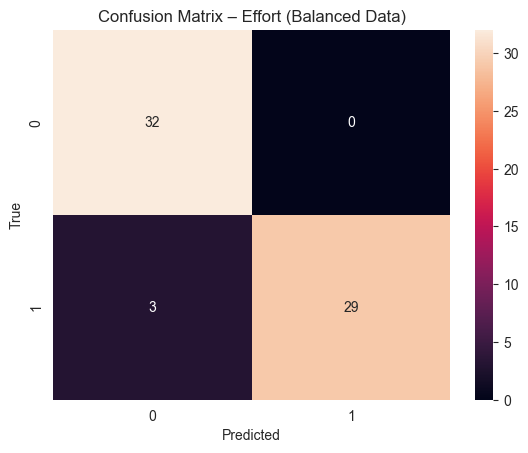


======================== Performance Self-Talk ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Performance Self-Talk
0    372
1     31
Name: count, dtype: int64

Balanced class counts:
Performance Self-Talk
0    31
1    31
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8709677419354839
Logistic Regression Precision (Balanced Data): 0.8108108108108109
Logistic Regression Recall (Balanced Data): 0.967741935483871

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.81      0.97      0.88        31

    accuracy                           0.87        62
   macro avg       0.89      0.87      0.87        62
weighted avg       0.89      0.87      0.87        62



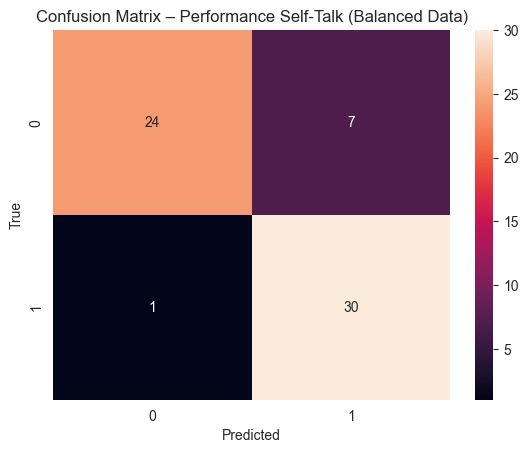


======================== Willpower ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Willpower
0    328
1     75
Name: count, dtype: int64

Balanced class counts:
Willpower
0    75
1    75
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8866666666666667
Logistic Regression Precision (Balanced Data): 0.9833333333333333
Logistic Regression Recall (Balanced Data): 0.7866666666666666

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.82      0.99      0.90        75
           1       0.98      0.79      0.87        75

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



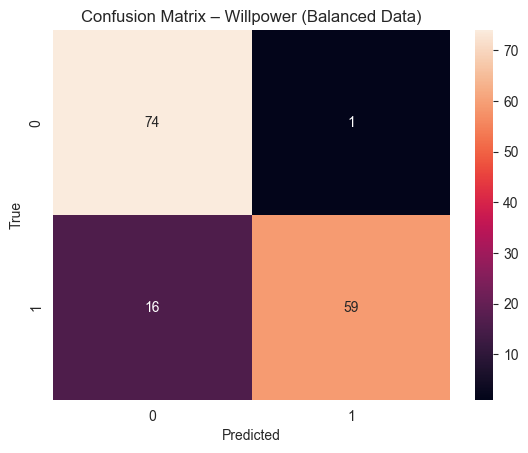

In [105]:
# Example: run for each code
codes = ['Effort', 'Performance Self-Talk', 'Willpower']  # adjust names to match your columns

results = {}
for code in codes:
    clf, X_bal, y_bal = run_balanced_logreg_for_code(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df
    )
    results[code] = {'clf': clf, 'X_bal': X_bal, 'y_bal': y_bal}


In [120]:
def reduced_feature_model_only(clf, X_bal, y_bal, code_name,
                               k_pos=20, k_neg=20):
    """
    Build and evaluate a reduced logistic regression model using:
    - top k_pos positive coefficients
    - top k_neg negative coefficients
    Evaluate on the same balanced dataset.
    """

    coef = clf.coef_[0]
    feature_names = X_bal.columns

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coef': coef
    })

    # select top positive features
    pos_df = coef_df[coef_df['coef'] > 0].nlargest(k_pos, 'coef')

    # select top negative features
    neg_df = coef_df[coef_df['coef'] < 0].nsmallest(k_neg, 'coef')

    # combine feature list
    selected_features = pd.concat([pos_df, neg_df])['feature'].unique().tolist()

    print(f"\n{code_name}: Selected {len(selected_features)} reduced features")
    # reduced dataset
    X_red = X_bal[selected_features]

    # fit reduced model
    clf_red = LogisticRegression(max_iter=1000)
    clf_red.fit(X_red, y_bal)

    # predictions
    y_pred = clf_red.predict(X_red)

    # performance report
    print("\nReduced Model Performance (Balanced Data):")
    print("Accuracy :", metrics.accuracy_score(y_bal, y_pred))
    print("Precision:", metrics.precision_score(y_bal, y_pred, zero_division=0))
    print("Recall   :", metrics.recall_score(y_bal, y_pred, zero_division=0))

    print("\nClassification Report:\n",
          metrics.classification_report(y_bal, y_pred, zero_division=0))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_bal, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Reduced Confusion Matrix – {code_name}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf_red, X_red, selected_features



Running REDUCED MODEL for Effort

======================== Effort ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Effort
0    371
1     32
Name: count, dtype: int64

Balanced class counts:
Effort
1    32
0    32
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.953125
Logistic Regression Precision (Balanced Data): 1.0
Logistic Regression Recall (Balanced Data): 0.90625

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.91      0.95        32

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



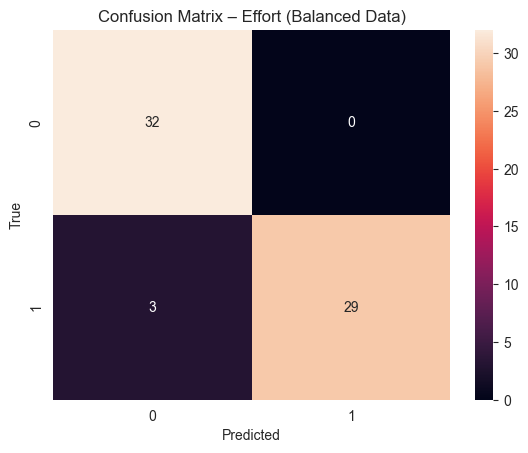


Effort: Selected 40 reduced features

Effort: Selected reduced features: Positive       feature      coef
11       work  0.723861
96       know  0.692470
30   question  0.598321
17       fail  0.597367
66       good  0.564331
24        try  0.489489
68       sure  0.479525
187     click  0.465089
51       need  0.451370
87      candy  0.389514
145  everyday  0.384793
474   motivat  0.368101
321     cause  0.310035
322     lisin  0.310035
148       mom  0.272869
477   domwhat  0.265766
244     agree  0.265710
245  somewhat  0.265710
50     mathia  0.256751
128      make  0.252645 &  Negative         feature      coef
67         self -0.726017
88        super -0.695276
323       class -0.667869
232       topic -0.648491
113           m -0.492942
69          yes -0.446932
158       study -0.446932
161   confident -0.446884
99          dad -0.439804
25          idk -0.362736
26       school -0.362731
222     skibidi -0.362707
223      toilet -0.362707
109         get -0.346095
19     moti

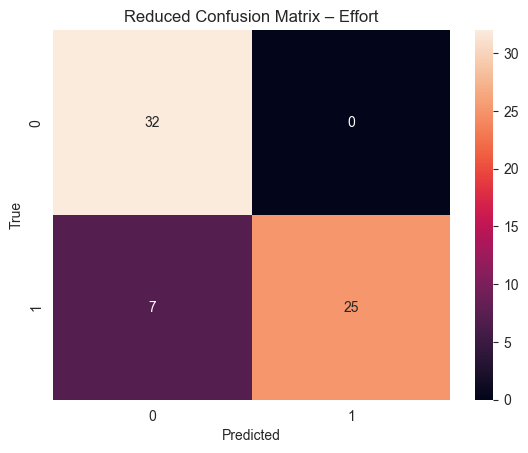


Running REDUCED MODEL for Performance Self-Talk

======================== Performance Self-Talk ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Performance Self-Talk
0    372
1     31
Name: count, dtype: int64

Balanced class counts:
Performance Self-Talk
0    31
1    31
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8709677419354839
Logistic Regression Precision (Balanced Data): 0.8108108108108109
Logistic Regression Recall (Balanced Data): 0.967741935483871

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.81      0.97      0.88        31

    accuracy                           0.87        62
   macro avg       0.89      0.87      0.87        62
weighted avg       0.89      0.87      0.87        62



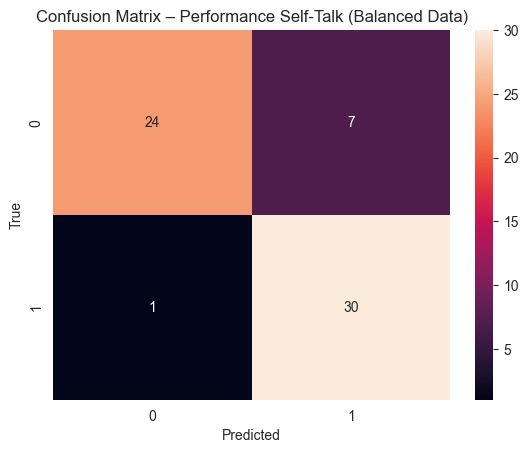


Performance Self-Talk: Selected 40 reduced features

Performance Self-Talk: Selected reduced features: Positive       feature      coef
159      calm  0.707634
24        try  0.608847
79       tell  0.599086
41    outside  0.466579
538    batman  0.460698
21         go  0.456339
109       get  0.455286
0       awaly  0.450776
2        well  0.450667
260   mistake  0.439967
23       keep  0.427191
186      push  0.416827
266       idl  0.416785
52       easy  0.409680
86     tellig  0.401059
85   possible  0.400985
524   collage  0.341914
201      able  0.341838
420      lean  0.335256
105    ghelpe  0.335201 &  Negative          feature      coef
19      motivate -0.816845
50        mathia -0.666316
68          sure -0.556293
547     motavite -0.472639
232        topic -0.423667
118         like -0.419171
15         solve -0.419169
187        click -0.419149
331         have -0.406216
134          bad -0.406207
43          math -0.400710
216  affirmation -0.385745
377        staar -0.

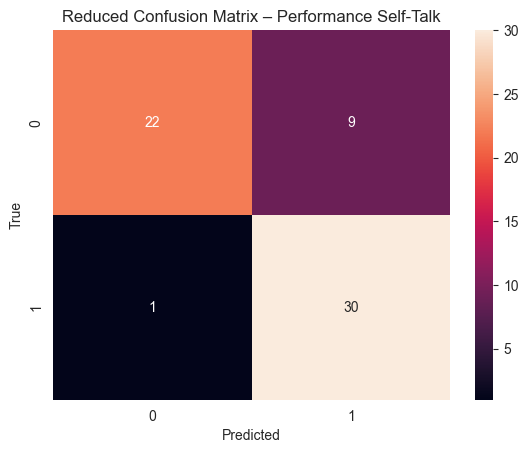


Running REDUCED MODEL for Willpower

======================== Willpower ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Willpower
0    328
1     75
Name: count, dtype: int64

Balanced class counts:
Willpower
0    75
1    75
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.8866666666666667
Logistic Regression Precision (Balanced Data): 0.9833333333333333
Logistic Regression Recall (Balanced Data): 0.7866666666666666

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.82      0.99      0.90        75
           1       0.98      0.79      0.87        75

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



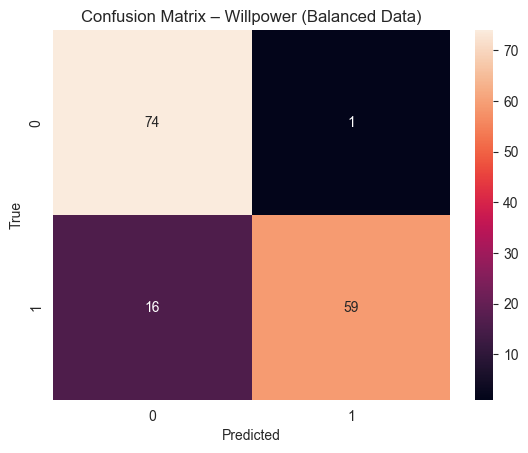


Willpower: Selected 40 reduced features

Willpower: Selected reduced features: Positive          feature      coef
8          focus  1.250741
216  affirmation  0.991682
39          want  0.818959
14           not  0.613589
42         grade  0.575576
134          bad  0.567916
22          hard  0.524693
26        school  0.511889
85      possible  0.491405
300       normal  0.482670
189        stuff  0.482581
99           dad  0.478744
51          need  0.475996
414      trouble  0.458829
44      practice  0.451790
119     bobathan  0.444865
206        matha  0.444865
220        thank  0.444865
270      bunssss  0.444865
388        jinum  0.444865 &  Negative         feature      coef
508       bring -0.749114
67         self -0.670441
45      problem -0.643258
0         awaly -0.597437
194      people -0.573755
252     improve -0.562488
543      belive -0.553463
41      outside -0.538424
255       jusrt -0.517549
256          ut -0.517549
72       couple -0.501397
73     orkpsace -0.5

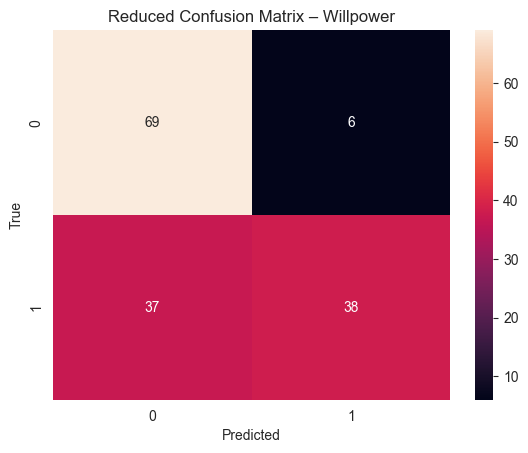

In [121]:
codes = ['Effort', 'Performance Self-Talk', 'Willpower']

reduced_results = {}

for code in codes:
    print("\n==============================")
    print(f"Running REDUCED MODEL for {code}")
    print("==============================")

    # Step 1: get balanced dataset + full model
    clf_full, X_bal, y_bal = run_balanced_logreg_for_code(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df
    )

    # Step 2: reduced model ONLY
    clf_red, X_red, feature_list = reduced_feature_model_only(
        clf=clf_full,
        X_bal=X_bal,
        y_bal=y_bal,
        code_name=code,
        k_pos=20,
        k_neg=20
    )

    # save only reduced model results
    reduced_results[code] = {
        'clf_reduced': clf_red,
        'X_red': X_red,
        'features': feature_list,
        'y_bal': y_bal
    }


In [122]:
def get_positive_negative_features(clf_red, X_red):
    coef = clf_red.coef_[0]
    coef_series = pd.Series(coef, index=X_red.columns)

    pos = coef_series[coef_series > 0].sort_values(ascending=False)
    neg = coef_series[coef_series < 0].sort_values()

    return pos, neg


In [123]:
pos, neg = get_positive_negative_features(
    reduced_results['Willpower']['clf_reduced'],
    reduced_results['Willpower']['X_red']
)


In [124]:
print("\nPositive Features:")
print(pos)

print("\nNegative Features:")
print(neg)



Positive Features:
focus          1.195306
affirmation    0.895476
want           0.868247
need           0.662126
possible       0.659753
not            0.610255
grade          0.573758
dad            0.561723
bad            0.552382
practice       0.478693
school         0.455642
bobathan       0.446084
bunssss        0.446084
thank          0.446084
matha          0.446084
jinum          0.446084
hard           0.431421
normal         0.401235
stuff          0.401161
trouble        0.380357
dtype: float64

Negative Features:
bring        -0.746540
outside      -0.649805
problem      -0.592890
people       -0.572310
focused      -0.545919
self         -0.524092
jusrt        -0.512722
ut           -0.512722
awaly        -0.473529
easy         -0.473515
belive       -0.472503
work         -0.464529
improve      -0.444085
couple       -0.336883
orkpsace     -0.336883
way          -0.329520
mylef        -0.324834
overthinke   -0.324834
walk         -0.324086
note         -0.324041
dtype